In [1]:
from SFXGBoost.Model import SFXGBoost, devide_D_Train
from SFXGBoost.config import Config, MyLogger
from SFXGBoost.dataset.datasetRetrieval import getDataBase
from ddsketch import DDSketch
# from SFXGBoost.data_structure.databasestructure import QuantiledDataBase,  DataBase
import numpy as np
from SFXGBoost.view.plotter import plot_loss
import pickle
import os
from copy import deepcopy
import pandas as pd
from datetime import date
import time

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from SFXGBoost.Model import SFXGBoost
import pickle
import pandas as pd
import numpy as np
from SFXGBoost.dataset.datasetRetrieval import getDataBase
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

In [3]:
dataset = 'iris' #'credit_card_fraud' 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=0.3, #0.3, 0.75
        max_depth=6,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

from sklearn import datasets

iris = datasets.load_iris()

X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

fName = iris.feature_names



# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

# X_train = data.drop('Class', axis=1).values
# y_train = encoder.fit_transform(data['Class'].values.reshape(-1, 1)).toarray()
# fName = data.drop('Class', axis=1).columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)


res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(quantiles)

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))

start DB = 0, end = 50, myrank = 1
start DB = 50, end = 100, myrank = 2
start DB = 100, end = 150, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


TypeError: list indices must be integers or slices, not NoneType

Accuracy: 0.9333333333333333
Confusion Matrix:
[[10  0  0]
 [ 0  8  2]
 [ 0  0 10]]
ROC AUC (macro avg): 0.9983333333333334
ROC AUC (micro avg): 0.995
F1 Score (macro avg): 0.9326599326599326
F1 Score (class 0): 1.0
F1 Score (class 1): 0.8888888888888888
F1 Score (class 2): 0.9090909090909091


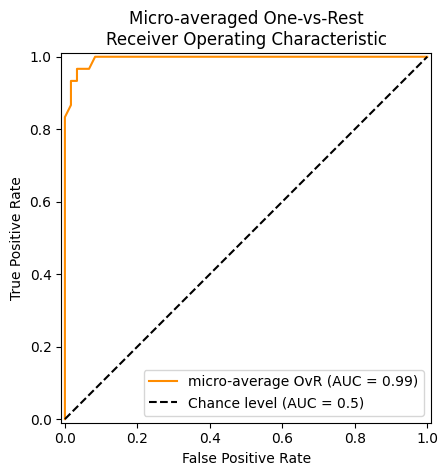

<Figure size 640x480 with 0 Axes>

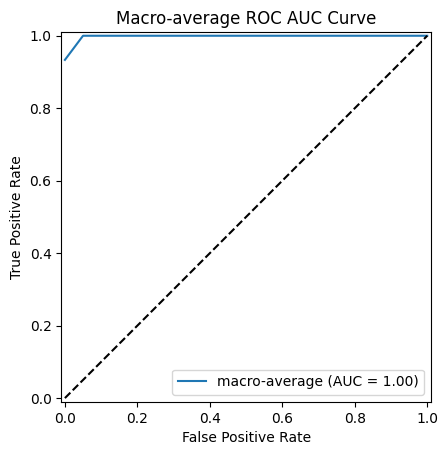

In [4]:
# from federboost import NUM_CLIENTS

# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase('healthcare', POSSIBLE_PATHS, False, 10_000)()

NUM_CLIENTS = 3

bst_clients = []
# E:\OneDrive\UOB\xgboost-comprehensive\FederBoost\Saves\Jun-24-2024\model_10_29_credit_card_fraud_1.pkl
for i in range(NUM_CLIENTS):
    i += 1
    bst:SFXGBoost = pickle.load(open(f"./Saves/Jun-24-2024/model_15_22_iris_{i}.pkl", 'rb'))
    bst_clients.append(bst)

X_train = np.concatenate([bst_clients[i].X_train for i in range(NUM_CLIENTS)])
X_test = np.concatenate([bst_clients[i].X_test for i in range(NUM_CLIENTS)])
y_train = np.concatenate([bst_clients[i].y_train for i in range(NUM_CLIENTS)])
y_test = np.concatenate([bst_clients[i].y_test for i in range(NUM_CLIENTS)])


n_classes = y_test.shape[1]
y_test_labels = np.argmax(y_test, axis=1)

y_pred = bst.predict(X_test)
y_pred_prab = bst.predict_proba(X_test)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='macro')
print(f"ROC AUC (macro avg): {roc_auc}")

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='micro')
print(f"ROC AUC (micro avg): {roc_auc}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"F1 Score (macro avg): {f1}")

# Calculate F1 score for each class
f1_per_class = f1_score(y_test_labels, y_pred, average=None)
for i, score in enumerate(f1_per_class):
    print(f"F1 Score (class {i}): {score}")

import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred_prab.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prab[:, i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred_prab, average="macro", multi_class="ovr")

# Plot macro-average ROC curve
plt.figure()
RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], estimator_name='macro-average').plot()

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC AUC Curve')
plt.legend(loc="best")
plt.show()

# print(f'Macro-average ROC AUC: {roc_auc["macro"]}')

C:\Users\hddpp\AppData\Local\Temp\ipykernel_9020\3887139302.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\


start DB = 0, end = 9493, myrank = 1
start DB = 9493, end = 18987, myrank = 2
start DB = 18987, end = 28481, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 5:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 6:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 7:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Train loss: 0.6903689763598861
Test loss: 0.6902912497348614
Time for tree 0: 50.0s
Tree 1:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending split

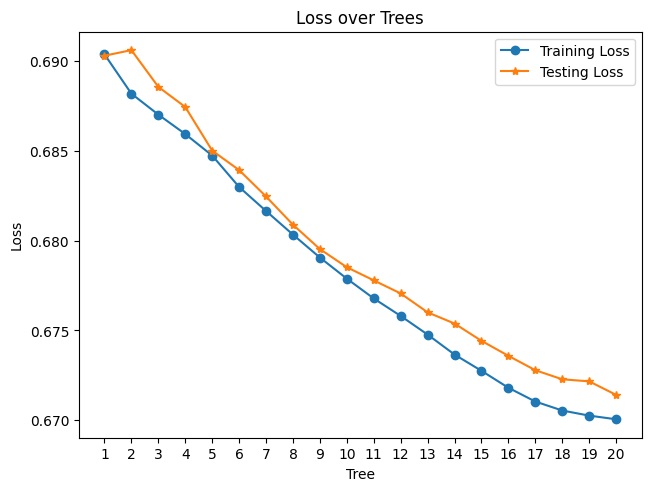

In [6]:
dataset =  'credit_card_fraud'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=1.5, #0.3, 0.75
        max_depth=8,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
    .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
    .sample(frac=1, random_state=1, replace=False)

X_train = data.drop('Class', axis=1).values
y_train = encoder.fit_transform(data['Class'].values.reshape(-1, 1)).toarray()
fName = data.drop('Class', axis=1).columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)

# sketchs = [DDSketch() for _ in range(total_users)]
# sketch = DDSketch()
res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(quantiles)

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))

Accuracy: 0.9994734070563455
Confusion Matrix:
[[5684    3]
 [   0   10]]
ROC AUC (macro avg): 0.9997186565851943
ROC AUC (micro avg): 0.5378551956600436
F1 Score (macro avg): 0.9346506941762607
F1 Score (class 0): 0.9997361709612171
F1 Score (class 1): 0.8695652173913043


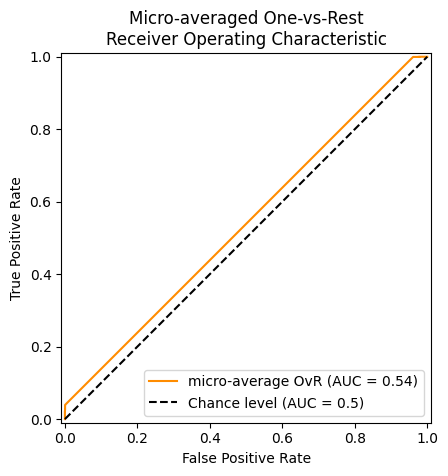

<Figure size 640x480 with 0 Axes>

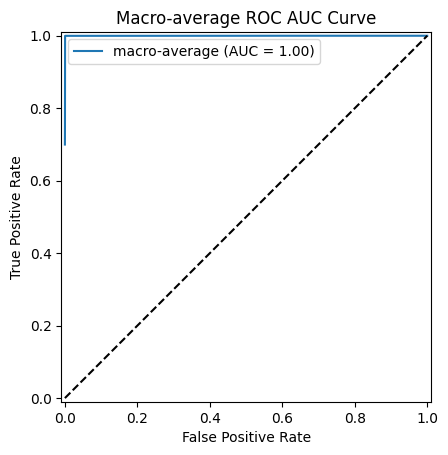

In [8]:
bst_clients = []
# E:\OneDrive\UOB\xgboost-comprehensive\FederBoost\Saves\Jun-24-2024\model_10_29_credit_card_fraud_1.pkl
for i in range(NUM_CLIENTS):
    i += 1
    bst:SFXGBoost = pickle.load(open(f"./Saves/Jun-24-2024/model_15_41_credit_card_fraud_{i}.pkl", 'rb'))
    bst_clients.append(bst)

X_train = np.concatenate([bst_clients[i].X_train for i in range(NUM_CLIENTS)])
X_test = np.concatenate([bst_clients[i].X_test for i in range(NUM_CLIENTS)])
y_train = np.concatenate([bst_clients[i].y_train for i in range(NUM_CLIENTS)])
y_test = np.concatenate([bst_clients[i].y_test for i in range(NUM_CLIENTS)])


n_classes = y_test.shape[1]
y_test_labels = np.argmax(y_test, axis=1)

y_pred = bst.predict(X_test)
y_pred_prab = bst.predict_proba(X_test)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='macro')
print(f"ROC AUC (macro avg): {roc_auc}")

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='micro')
print(f"ROC AUC (micro avg): {roc_auc}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"F1 Score (macro avg): {f1}")

# Calculate F1 score for each class
f1_per_class = f1_score(y_test_labels, y_pred, average=None)
for i, score in enumerate(f1_per_class):
    print(f"F1 Score (class {i}): {score}")

import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred_prab.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prab[:, i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred_prab, average="macro", multi_class="ovr")

# Plot macro-average ROC curve
plt.figure()
RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], estimator_name='macro-average').plot()

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC AUC Curve')
plt.legend(loc="best")
plt.show()

# print(f'Macro-average ROC AUC: {roc_auc["macro"]}')

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [4]:
path = r'E:\OneDrive - National University of Singapore\2023-2024 SEM 2\BT5153 Applied Machine Learning for Business Analytics\kaggle competition'

In [5]:
profile_df = pd.read_csv(path + r'\profile.csv')
train_label_df = pd.read_csv(path + r'\train_label.csv')
trx_df = pd.read_csv(path + r'\trx_data.csv')
trx_df['transaction_time'] = pd.to_datetime(trx_df['transaction_time'])
trx_df['month'] = trx_df['transaction_time'].dt.month
trx_df['day'] = trx_df['transaction_time'].dt.day
trx_df['hour'] = trx_df['transaction_time'].dt.hour
trx_df['day_of_week'] = trx_df['transaction_time'].dt.day_name()
deviation = trx_df.groupby(['user_id'])['gtv'].std().fillna(0)

df1 = trx_df.groupby(['user_id', 'transaction_type', 'month'])['gtv'].count().unstack(['transaction_type', 'month']).fillna(0)
df1.columns = ['count_'+'_'.join([str(i) for i in col]) for col in df1.columns]

df2 = trx_df.groupby(['user_id', 'transaction_type', 'month'])['gtv'].sum().unstack(['transaction_type', 'month']).fillna(0)
df2.columns = ['sum_'+'_'.join([str(i) for i in col]) for col in df2.columns]

df = pd.concat([df1, df2], axis=1)
df = df.merge(trx_df.groupby(['user_id', 'asset_type'])['gtv'].sum().unstack('asset_type').fillna(0), on='user_id', how='left')
df['std'] = deviation

df['sum_SUM_4'] = df['sum_SELL_4'] + df['sum_BUY_4']
df['sum_SUM_5'] = df['sum_SELL_5'] + df['sum_BUY_5']
df['sum_DIFF_4'] = df['sum_SELL_4'] - df['sum_BUY_4']
df['sum_DIFF_5'] = df['sum_SELL_5'] - df['sum_BUY_5']
df['sum_INC'] = (df['sum_SUM_5'] / df['sum_SUM_4']).replace([float('inf'), -float('inf'),np.nan], 0)
df['sum_SUM_agg'] = df['sum_SUM_4'] + df['sum_SUM_5']
df['sum_DIFF_agg'] = df['sum_DIFF_4'] + df['sum_DIFF_5']

df['count_SUM_4'] = df['count_SELL_4'] + df['count_BUY_4']
df['count_SUM_5'] = df['count_SELL_5'] + df['count_BUY_5']
df['count_DIFF_4'] = df['count_SELL_4'] - df['count_BUY_4']
df['count_DIFF_5'] = df['count_SELL_5'] - df['count_BUY_5']
df['count_INC'] = (df['count_SUM_5'] / df['count_SUM_4']).replace([float('inf'), -float('inf'),np.nan], 0)
df['count_SUM_agg'] = df['count_SUM_4'] + df['count_SUM_5']
df['count_DIFF_agg'] = df['count_DIFF_4'] + df['count_DIFF_5']

# Extract date from 'transaction_time'
trx_df['date'] = trx_df['transaction_time'].dt.date

# Count unique dates for each id
unique_days_per_id = trx_df.groupby('user_id')['date'].nunique()

df['trx_days'] = unique_days_per_id

# Find the last transaction day for each id
last_transaction_day = trx_df.groupby('user_id')['transaction_time'].max()

# Calculate the number of days between the last transaction day and 2022-06-01
days_to_2022_06_01 = (pd.to_datetime('2022-06-01') - last_transaction_day).dt.days

df['trx_gap'] = days_to_2022_06_01

combined_df = df.merge(profile_df, left_index=True, right_on='user_id')
combined_df.set_index('user_id', inplace=True)
# combined_df = combined_df.drop('user_id',axis= 1)

# Merge combined_df with train_label_df on user_id
train_df = combined_df.merge(train_label_df, on='user_id')
train_df = train_df.drop('user_id', axis=1)

# Create test_df by excluding the user_ids present in train_df
test_df = combined_df[~combined_df.index.isin(train_label_df['user_id'])]
# test_df = test_df.drop('user_id', axis=1)

print(train_df.shape, test_df.shape)
print(len(train_df) /(len(train_df)+ len(test_df)))

(150741, 41) (37686, 40)
0.7999968157429668


In [6]:
train_df.columns

Index(['count_BUY_4', 'count_BUY_5', 'count_SELL_5', 'count_SELL_4',
       'sum_BUY_4', 'sum_BUY_5', 'sum_SELL_5', 'sum_SELL_4', 'crypto', 'fx',
       'gold', 'gss', 'idss', 'mfund', 'stock_index', 'std', 'sum_SUM_4',
       'sum_SUM_5', 'sum_DIFF_4', 'sum_DIFF_5', 'sum_INC', 'sum_SUM_agg',
       'sum_DIFF_agg', 'count_SUM_4', 'count_SUM_5', 'count_DIFF_4',
       'count_DIFF_5', 'count_INC', 'count_SUM_agg', 'count_DIFF_agg',
       'trx_days', 'trx_gap', 'mobile_brand_name', 'mobile_marketing_name',
       'age_in_year', 'gender_name', 'marital_status', 'education_background',
       'income_level', 'occupation', 'tgt'],
      dtype='object')

In [28]:
train_df_shuffle = train_df.groupby(['tgt']).apply(lambda x: x.sample(frac=0.1,replace=False)).sample(frac=1, random_state=1, replace= False ).reset_index(drop=True)

C:\Users\hddpp\AppData\Local\Temp\ipykernel_3220\889562610.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_shuffle = train_df.groupby(['tgt']).apply(lambda x: x.sample(frac=0.1,replace=False)).sample(frac=1, random_state=1, replace= False ).reset_index(drop=True)


In [29]:
y = train_df_shuffle['tgt']
train_df_shuffle.shape

(15074, 41)

In [30]:
# ['BUY_4', 'BUY_5', 'SELL_5', 'SELL_4', 'SUM_4', 'SUM_5', 'DIFF_4',
#        'DIFF_5', 'INC', 'mobile_brand_name', 'mobile_marketing_name',
#        'age_in_year', 'gender_name', 'marital_status', 'education_background',
#        'income_level', 'occupation', 'tgt']

# Define columns for each type of encoder:
numerical_columns = ['count_BUY_4', 'count_BUY_5', 'count_SELL_5', 'count_SELL_4',
       'sum_BUY_4', 'sum_BUY_5', 'sum_SELL_5', 'sum_SELL_4', 'sum_SUM_4',
       'sum_SUM_5', 'sum_DIFF_4', 'sum_DIFF_5', 'sum_INC', 'count_SUM_4',
       'count_SUM_5', 'count_DIFF_4', 'count_DIFF_5', 'count_INC', 'sum_SUM_agg' , 
       'sum_DIFF_agg', 'count_SUM_agg', 'count_DIFF_agg',
       'crypto', 'fx','trx_days', 'trx_gap',
       'gold', 'gss', 'idss', 'mfund', 'stock_index','std',
       'age_in_year']  # numerical columns
ordinal_columns = ['education_background', 'income_level']     # categorical columns for ordinal encoding
onehot_columns = [ 'gender_name', 'marital_status', 'occupation'] # categorical columns for onehot encoding
onehot_pca_columns = ['mobile_brand_name', 'mobile_marketing_name'] # categorical columns for onehot encoding with PCA

# Define the encoders
ordinal = OrdinalEncoder(categories = [
                            ['others', 'primary school','junior high school', 'senior high school', 
                                        'diploma','undegraduate', 'post graduate'], # Savings account
                            ['< 10 million/year','> 10 – 50 million/year', 
                             '> 50 – 100 million/year','> 100 – 500 million/year', '> 500 million – 1 billion/year',]],
                         handle_unknown = 'use_encoded_value',  
                         unknown_value = -1
                        )

onehot = OneHotEncoder(categories = [
                            ['Male', 'Female',np.nan], # Sex
                            [ 'single', 'married', 'divorced',np.nan], # Housing
                            [ 'private employee', 'others', 'student', 'housewife', 'civil servant','lecturer/teacher', 
                             'indonesian national armed force/indonesian national police','retired',np.nan], # Occupation
                         ],
                         handle_unknown = 'error',
                         drop='first' # to return k-1, use drop=False to return k
                        )
scaler = StandardScaler()
onehot_pca = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False)),
    ('pca', PCA(n_components=10))
])

# Combine them!
preprocessor = ColumnTransformer([
   #(nickname, transformer to apply, columns to apply to)   
    ('numerical', 'passthrough', numerical_columns),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_columns),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_columns),                 # <- apply onehot encoder to the onehot_columns
    ('onehot_pca', onehot_pca, onehot_pca_columns)                 # <- apply onehot encoder to the onehot_columns
])

preprocessor

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['count_BUY_4', 'count_BUY_5', 'count_SELL_5',
                                  'count_SELL_4', 'sum_BUY_4', 'sum_BUY_5',
                                  'sum_SELL_5', 'sum_SELL_4', 'sum_SUM_4',
                                  'sum_SUM_5', 'sum_DIFF_4', 'sum_DIFF_5',
                                  'sum_INC', 'count_SUM_4', 'count_SUM_5',
                                  'count_DIFF_4', 'count_DIFF_5', 'count_INC',
                                  'sum_SUM_agg', 'sum_DIFF_agg',
                                  'count_SUM_agg', 'count_...
                                                            'civil servant',
                                                            'lecturer/teacher',
                                                            'indonesian '
                                                            'national armed '
                                                            'force/indonesian '
                                                            'national police',
                                                            'retired', nan]],
                                               drop='first'),
                                 ['gender_name', 'marital_status',
                                  'occupation']),
                                ('onehot_pca',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca',
                                                  PCA(n_components=10))]),
                                 ['mobile_brand_name',
                                  'mobile_marketing_name'])])

In [31]:
train_df_shuffle

,count_BUY_4,count_BUY_5,count_SELL_5,count_SELL_4,sum_BUY_4,sum_BUY_5,sum_SELL_5,sum_SELL_4,crypto,fx,...,trx_gap,mobile_brand_name,mobile_marketing_name,age_in_year,gender_name,marital_status,education_background,income_level,occupation,tgt
0,2.0,0.0,0.0,0.0,1846.457143,0.000000,0.000000,0.000000,0.000000,0.000000,...,36,OPPO,a53,26.0,Male,NaN,NaN,NaN,NaN,0
1,1.0,1.0,1.0,1.0,48.516071,32.742857,37.016071,48.507143,85.532143,0.000000,...,19,OPPO,reno4,21.0,Male,single,senior high school,> 10 – 50 million/year,student,0
2,2.0,4.0,3.0,2.0,4332.241071,10990.207143,11031.853571,4116.605357,30307.389286,0.000000,...,11,Samsung,galaxy a6,24.0,Female,single,diploma,< 10 million/year,student,0
3,18.0,3.0,1.0,3.0,396.787500,35.712500,18.258929,131.930357,582.689286,0.000000,...,15,Vivo,s1,29.0,Female,married,senior high school,< 10 million/year,housewife,1
4,7.0,10.0,11.0,6.0,7380.673214,1539.516071,1452.210714,7238.923214,17611.323214,0.000000,...,2,Samsung,galaxy a21s,29.0,Male,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15069,2.0,0.0,0.0,1.0,3589.285714,0.000000,0.000000,3564.491071,7153.776786,0.000000,...,34,Samsung,galaxy a03,64.0,Male,NaN,NaN,NaN,NaN,0
15070,0.0,2.0,2.0,0.0,0.000000,1814.276786,1801.248214,0.000000,3615.525000,0.000000,...,11,OPPO,a95,22.0,Female,married,senior high school,< 10 million/year,housewife,0
15071,0.0,2.0,122.0,75.0,0.000000,2142.371429,159161.589286,106593.016071,0.000000,0.000000,...,0,Realme,5,26.0,Male,single,junior high school,< 10 million/year,student,1
15072,6.0,9.0,6.0,5.0,8575.964286,15123.194643,8516.050000,9072.798214,40755.530357,265.730357,...,16,Xiaomi,redmi 9a,24.0,Male,single,senior high school,< 10 million/year,private employee,0


In [32]:
train_df_shuffle = pd.DataFrame(
    data = preprocessor.fit_transform(train_df_shuffle),
    columns = preprocessor.get_feature_names_out(), # <- get the encoded feature names
    index = train_df_shuffle.index
)
train_df_shuffle

,numerical__count_BUY_4,numerical__count_BUY_5,numerical__count_SELL_5,numerical__count_SELL_4,numerical__sum_BUY_4,numerical__sum_BUY_5,numerical__sum_SELL_5,numerical__sum_SELL_4,numerical__sum_SUM_4,numerical__sum_SUM_5,...,onehot_pca__pca0,onehot_pca__pca1,onehot_pca__pca2,onehot_pca__pca3,onehot_pca__pca4,onehot_pca__pca5,onehot_pca__pca6,onehot_pca__pca7,onehot_pca__pca8,onehot_pca__pca9
0,2.0,0.0,0.0,0.0,1846.457143,0.000000,0.000000,0.000000,1846.457143,0.000000,...,-0.167171,0.684347,-0.542819,-0.162809,-0.050053,0.000264,0.000070,-0.000274,-0.006756,0.006066
1,1.0,1.0,1.0,1.0,48.516071,32.742857,37.016071,48.507143,97.023214,69.758929,...,-0.164454,0.671747,-0.531502,-0.157681,-0.046115,0.000342,0.000269,0.000951,-0.005134,0.003476
2,2.0,4.0,3.0,2.0,4332.241071,10990.207143,11031.853571,4116.605357,8448.846429,22022.060714,...,-0.567544,-0.610009,-0.139257,-0.113483,-0.039543,0.000689,0.001081,-0.068909,-0.055053,-0.008237
3,18.0,3.0,1.0,3.0,396.787500,35.712500,18.258929,131.930357,528.717857,53.971429,...,-0.116746,0.302624,0.815285,-0.207353,-0.053193,0.000799,0.001348,0.006902,-0.009669,-0.002102
4,7.0,10.0,11.0,6.0,7380.673214,1539.516071,1452.210714,7238.923214,14619.596429,2991.726786,...,-0.571587,-0.614932,-0.140530,-0.115049,-0.040904,0.000741,0.001185,-0.075384,-0.060492,-0.009100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15069,2.0,0.0,0.0,1.0,3589.285714,0.000000,0.000000,3564.491071,7153.776786,0.000000,...,-0.571587,-0.614932,-0.140530,-0.115049,-0.040904,0.000741,0.001185,-0.075384,-0.060492,-0.009101
15070,0.0,2.0,2.0,0.0,0.000000,1814.276786,1801.248214,0.000000,0.000000,3615.525000,...,-0.166929,0.683223,-0.541807,-0.162346,-0.049681,0.000289,0.000155,0.000281,-0.006360,0.005121
15071,0.0,2.0,122.0,75.0,0.000000,2142.371429,159161.589286,106593.016071,106593.016071,161303.960714,...,-0.055175,0.097138,0.075759,0.967071,-0.121928,0.001949,0.003585,0.018387,-0.026689,-0.005916
15072,6.0,9.0,6.0,5.0,8575.964286,15123.194643,8516.050000,9072.798214,17648.762500,23639.244643,...,0.819707,-0.266087,-0.093517,-0.097127,-0.037219,-0.081683,-0.165692,-0.010331,-0.000404,-0.042804


In [33]:
train_df_shuffle.shape

(15074, 58)

In [51]:
train_df_shuffle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15074 entries, 0 to 15073
Data columns (total 58 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   numerical__count_BUY_4                                                         15074 non-null  float64
 1   numerical__count_BUY_5                                                         15074 non-null  float64
 2   numerical__count_SELL_5                                                        15074 non-null  float64
 3   numerical__count_SELL_4                                                        15074 non-null  float64
 4   numerical__sum_BUY_4                                                           15074 non-null  float64
 5   numerical__sum_BUY_5                                                           15074 non-null  float64
 6   numerical__sum_SELL_5 

start DB = 0, end = 5024, myrank = 1
start DB = 5024, end = 10049, myrank = 2
start DB = 10049, end = 15073, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 5:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 6:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 7:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Train loss: 0.692127432429085
Test loss: 0.6923409323578685
Time for tree 0: 90.0s
Tree 1:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits

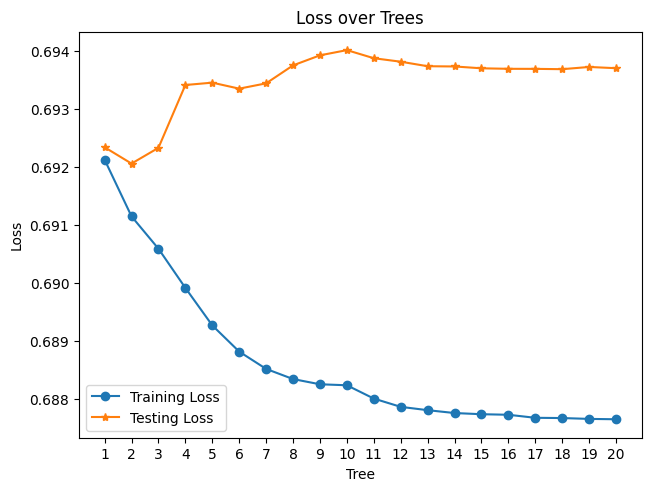

In [29]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=0.3, #0.3, 0.75
        max_depth=8,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)

# sketchs = [DDSketch() for _ in range(total_users)]
# sketch = DDSketch()
res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(quantiles)

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))


Accuracy: 0.7257048092868988
Confusion Matrix:
[[2164   23]
 [ 804   24]]
ROC AUC (macro avg): 0.5055466094113439
ROC AUC (micro avg): 0.5026326081037599
F1 Score (macro avg): 0.4472151863655258
F1 Score (class 0): 0.8395732298739088
F1 Score (class 1): 0.054857142857142854


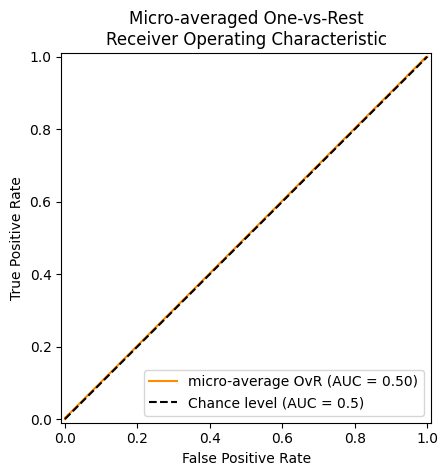

<Figure size 640x480 with 0 Axes>

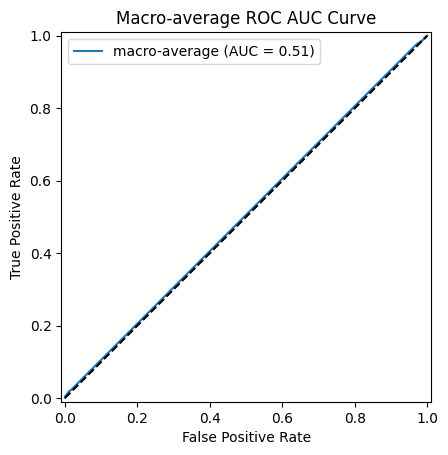

In [32]:
bst_clients = []
# E:\OneDrive\UOB\xgboost-comprehensive\FederBoost\Saves\Jun-24-2024\model_10_29_credit_card_fraud_1.pkl
for i in range(NUM_CLIENTS):
    i += 1
    bst:SFXGBoost = pickle.load(open(f"./Saves/Jun-24-2024/model_17_38_whales_prediction_{i}.pkl", 'rb'))
    bst_clients.append(bst)

X_train = np.concatenate([bst_clients[i].X_train for i in range(NUM_CLIENTS)])
X_test = np.concatenate([bst_clients[i].X_test for i in range(NUM_CLIENTS)])
y_train = np.concatenate([bst_clients[i].y_train for i in range(NUM_CLIENTS)])
y_test = np.concatenate([bst_clients[i].y_test for i in range(NUM_CLIENTS)])


n_classes = y_test.shape[1]
y_test_labels = np.argmax(y_test, axis=1)

y_pred = bst.predict(X_test)
y_pred_prab = bst.predict_proba(X_test)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='macro')
print(f"ROC AUC (macro avg): {roc_auc}")

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='micro')
print(f"ROC AUC (micro avg): {roc_auc}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"F1 Score (macro avg): {f1}")

# Calculate F1 score for each class
f1_per_class = f1_score(y_test_labels, y_pred, average=None)
for i, score in enumerate(f1_per_class):
    print(f"F1 Score (class {i}): {score}")

# import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred_prab.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prab[:, i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred_prab, average="macro", multi_class="ovr")

# Plot macro-average ROC curve
plt.figure()
RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], estimator_name='macro-average').plot()

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC AUC Curve')
plt.legend(loc="best")
plt.show()

# print(f'Macro-average ROC AUC: {roc_auc["macro"]}')

start DB = 0, end = 5024, myrank = 1
start DB = 5024, end = 10049, myrank = 2
start DB = 10049, end = 15073, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 5:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 6:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 7:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Train loss: 0.6927598867026977
Test loss: 0.6928251690663826
Time for tree 0: 78.0s
Tree 1:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending split

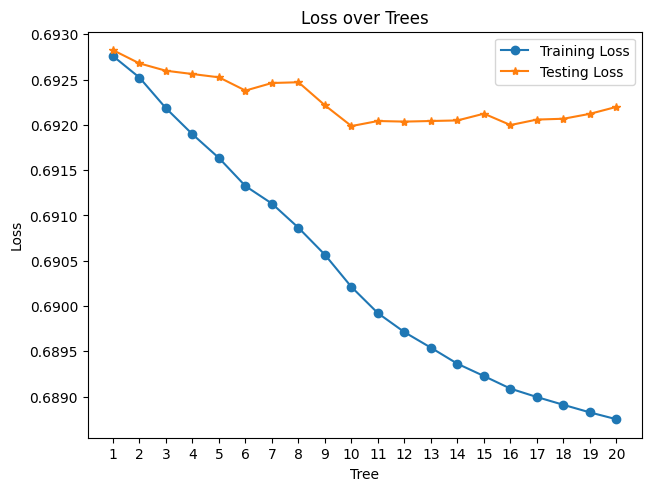

In [33]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=0.1, #0.3, 0.75
        max_depth=8,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)

# sketchs = [DDSketch() for _ in range(total_users)]
# sketch = DDSketch()
res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(quantiles)

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))


Accuracy: 0.7266998341625207
Confusion Matrix:
[[2162   25]
 [ 799   29]]
ROC AUC (macro avg): 0.5058420530627843
ROC AUC (micro avg): 0.5030065812452388
F1 Score (macro avg): 0.4528487385630243
F1 Score (class 0): 0.83993783993784
F1 Score (class 1): 0.06575963718820861


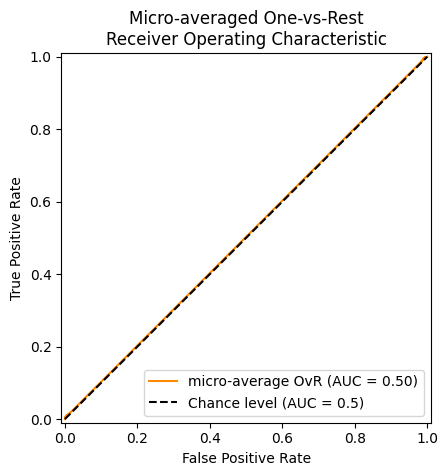

<Figure size 640x480 with 0 Axes>

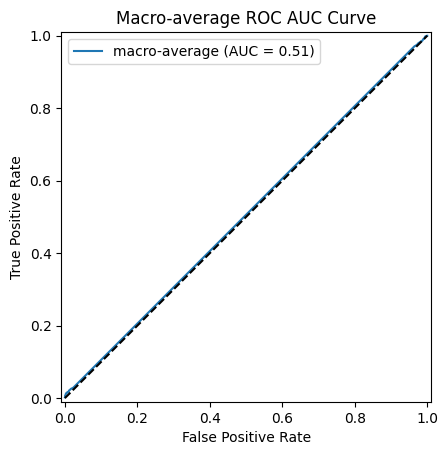

In [34]:
bst_clients = []
# E:\OneDrive\UOB\xgboost-comprehensive\FederBoost\Saves\Jun-24-2024\model_10_29_credit_card_fraud_1.pkl
for i in range(NUM_CLIENTS):
    i += 1
    bst:SFXGBoost = pickle.load(open(f"./Saves/Jun-24-2024/model_18_13_whales_prediction_{i}.pkl", 'rb'))
    bst_clients.append(bst)

X_train = np.concatenate([bst_clients[i].X_train for i in range(NUM_CLIENTS)])
X_test = np.concatenate([bst_clients[i].X_test for i in range(NUM_CLIENTS)])
y_train = np.concatenate([bst_clients[i].y_train for i in range(NUM_CLIENTS)])
y_test = np.concatenate([bst_clients[i].y_test for i in range(NUM_CLIENTS)])


n_classes = y_test.shape[1]
y_test_labels = np.argmax(y_test, axis=1)

y_pred = bst.predict(X_test)
y_pred_prab = bst.predict_proba(X_test)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='macro')
print(f"ROC AUC (macro avg): {roc_auc}")

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='micro')
print(f"ROC AUC (micro avg): {roc_auc}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"F1 Score (macro avg): {f1}")

# Calculate F1 score for each class
f1_per_class = f1_score(y_test_labels, y_pred, average=None)
for i, score in enumerate(f1_per_class):
    print(f"F1 Score (class {i}): {score}")

# import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred_prab.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prab[:, i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred_prab, average="macro", multi_class="ovr")

# Plot macro-average ROC curve
plt.figure()
RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], estimator_name='macro-average').plot()

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC AUC Curve')
plt.legend(loc="best")
plt.show()

# print(f'Macro-average ROC AUC: {roc_auc["macro"]}')

start DB = 0, end = 5024, myrank = 1
start DB = 5024, end = 10049, myrank = 2
start DB = 10049, end = 15073, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 5:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 6:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 7:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Train loss: 0.6925819652110627
Test loss: 0.6929879576407977
Time for tree 0: 82.0s
Tree 1:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending split

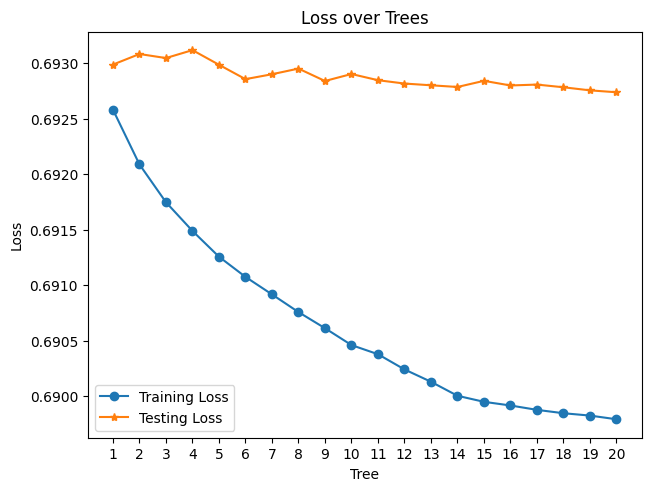

In [51]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=0.1, #0.3, 0.75
        max_depth=8,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)

# sketchs = [DDSketch() for _ in range(total_users)]
# sketch = DDSketch()
res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(np.unique(np.round(quantiles,4)))

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))


Accuracy: 0.7250414593698176
Confusion Matrix:
[[2170   17]
 [ 812   16]]
ROC AUC (macro avg): 0.5050438029727704
ROC AUC (micro avg): 0.5029746788445831
F1 Score (macro avg): 0.438393451176034
F1 Score (class 0): 0.8396208164054942
F1 Score (class 1): 0.03716608594657375


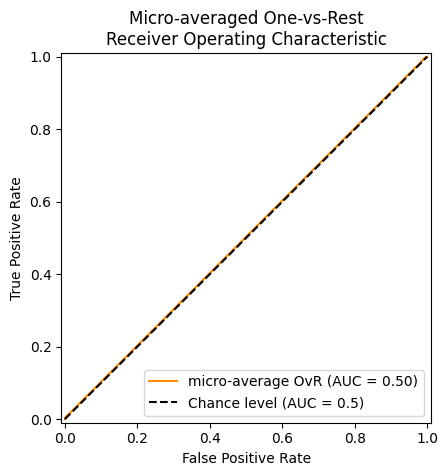

<Figure size 640x480 with 0 Axes>

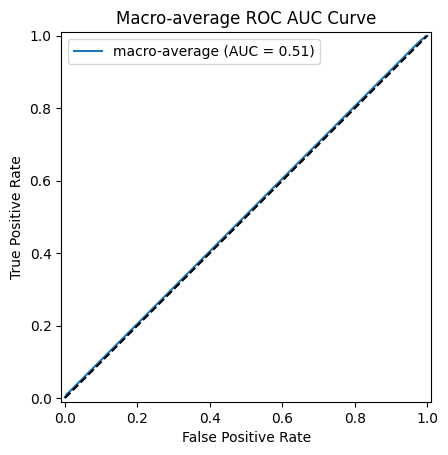

In [52]:
bst_clients = []
# E:\OneDrive\UOB\xgboost-comprehensive\FederBoost\Saves\Jun-24-2024\model_10_29_credit_card_fraud_1.pkl
for i in range(NUM_CLIENTS):
    i += 1
    bst:SFXGBoost = pickle.load(open(f"./Saves/Jun-25-2024/model_11_33_whales_prediction_{i}.pkl", 'rb'))
    bst_clients.append(bst)

X_train = np.concatenate([bst_clients[i].X_train for i in range(NUM_CLIENTS)])
X_test = np.concatenate([bst_clients[i].X_test for i in range(NUM_CLIENTS)])
y_train = np.concatenate([bst_clients[i].y_train for i in range(NUM_CLIENTS)])
y_test = np.concatenate([bst_clients[i].y_test for i in range(NUM_CLIENTS)])


n_classes = y_test.shape[1]
y_test_labels = np.argmax(y_test, axis=1)

y_pred = bst.predict(X_test)
y_pred_prab = bst.predict_proba(X_test)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='macro')
print(f"ROC AUC (macro avg): {roc_auc}")

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='micro')
print(f"ROC AUC (micro avg): {roc_auc}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"F1 Score (macro avg): {f1}")

# Calculate F1 score for each class
f1_per_class = f1_score(y_test_labels, y_pred, average=None)
for i, score in enumerate(f1_per_class):
    print(f"F1 Score (class {i}): {score}")

# import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred_prab.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prab[:, i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred_prab, average="macro", multi_class="ovr")

# Plot macro-average ROC curve
plt.figure()
RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], estimator_name='macro-average').plot()

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC AUC Curve')
plt.legend(loc="best")
plt.show()

# print(f'Macro-average ROC AUC: {roc_auc["macro"]}')

start DB = 0, end = 5024, myrank = 1
start DB = 5024, end = 10049, myrank = 2
start DB = 10049, end = 15073, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 5:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Train loss: 0.6931471805599454
Test loss: 0.6931471805599453
Time for tree 0: 8.0s
Tree 1:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits

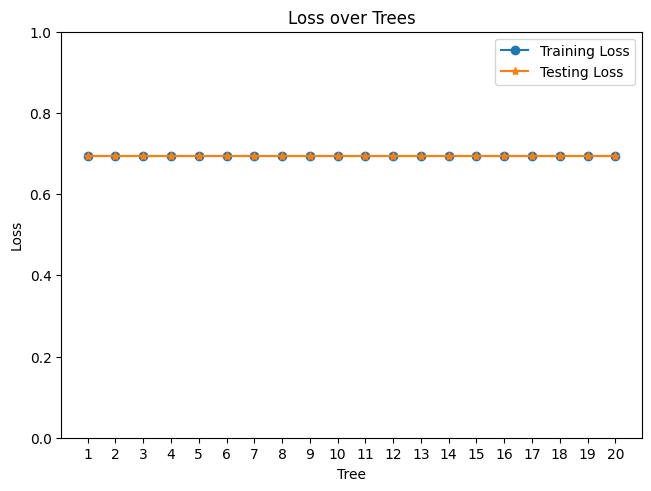

In [22]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=0.3, #0.3, 0.75
        max_depth=6,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)

# sketchs = [DDSketch() for _ in range(total_users)]
# sketch = DDSketch()
res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(np.unique(np.round(quantiles,4)))

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))


Accuracy: 0.7250414593698176
Confusion Matrix:
[[2185    2]
 [ 827    1]]
ROC AUC (macro avg): 0.500146893479034
ROC AUC (micro avg): 0.4996686000621546
F1 Score (macro avg): 0.4214764988823871
F1 Score (class 0): 0.8405462588959415
F1 Score (class 1): 0.0024067388688327317


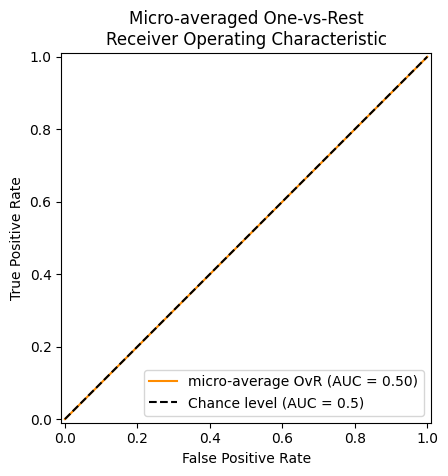

<Figure size 640x480 with 0 Axes>

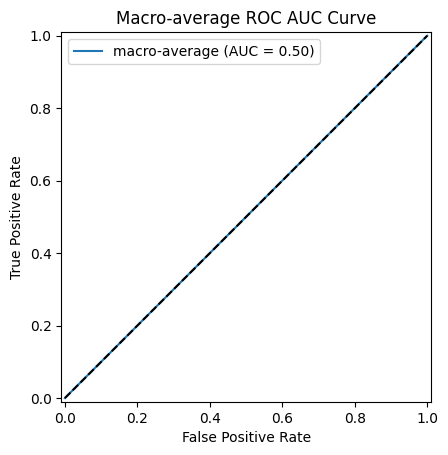

In [35]:
bst_clients = []
# E:\OneDrive\UOB\xgboost-comprehensive\FederBoost\Saves\Jun-24-2024\model_10_29_credit_card_fraud_1.pkl
for i in range(NUM_CLIENTS):
    i += 1
    bst:SFXGBoost = pickle.load(open(f"./Saves/Jun-25-2024/model_17_11_whales_prediction_{i}.pkl", 'rb'))
    bst_clients.append(bst)

X_train = np.concatenate([bst_clients[i].X_train for i in range(NUM_CLIENTS)])
X_test = np.concatenate([bst_clients[i].X_test for i in range(NUM_CLIENTS)])
y_train = np.concatenate([bst_clients[i].y_train for i in range(NUM_CLIENTS)])
y_test = np.concatenate([bst_clients[i].y_test for i in range(NUM_CLIENTS)])


n_classes = y_test.shape[1]
y_test_labels = np.argmax(y_test, axis=1)

y_pred = bst.predict(X_test)
y_pred_prab = bst.predict_proba(X_test)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='macro')
print(f"ROC AUC (macro avg): {roc_auc}")

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='micro')
print(f"ROC AUC (micro avg): {roc_auc}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"F1 Score (macro avg): {f1}")

# Calculate F1 score for each class
f1_per_class = f1_score(y_test_labels, y_pred, average=None)
for i, score in enumerate(f1_per_class):
    print(f"F1 Score (class {i}): {score}")

# import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred_prab.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prab[:, i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred_prab, average="macro", multi_class="ovr")

# Plot macro-average ROC curve
plt.figure()
RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], estimator_name='macro-average').plot()

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC AUC Curve')
plt.legend(loc="best")
plt.show()

# print(f'Macro-average ROC AUC: {roc_auc["macro"]}')

In [37]:
bst.trees.shape

(2, 20)

In [39]:
bst.trees[0][0].id

0

In [40]:
bst.trees[0][0].nNode

0

In [51]:
bst.trees[0][0].root.leftBranch

In [54]:
bst.trees[0][0].root.get_private_info()

'\nOwner ID:-1'

In [ ]:
bst.trees[0][0].root.get_private_info()

In [56]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=2, #0.3, 0.75
        max_depth=6,
        max_tree=100,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)

# sketchs = [DDSketch() for _ in range(total_users)]
# sketch = DDSketch()
res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(np.unique(np.round(quantiles,4)))

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))


start DB = 0, end = 5024, myrank = 1
start DB = 5024, end = 10049, myrank = 2
start DB = 10049, end = 15073, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 5:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Train loss: 0.6931471805599454
Test loss: 0.6931471805599453
Time for tree 0: 26.0s
Tree 1:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending split

KeyboardInterrupt: 

## Large Whale Dataset

In [47]:
train_df_shuffle = train_df.groupby(['tgt']).apply(lambda x: x.sample(frac=0.5, random_state=1)).sample(frac=1, random_state=1, replace= False ).reset_index(drop=True)

y = train_df_shuffle['tgt']
train_df_shuffle.shape

C:\Users\hddpp\AppData\Local\Temp\ipykernel_10144\3609818231.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_shuffle = train_df.groupby(['tgt']).apply(lambda x: x.sample(frac=0.5, random_state=1)).sample(frac=1, random_state=1, replace= False ).reset_index(drop=True)


(75370, 41)

In [48]:
# ['BUY_4', 'BUY_5', 'SELL_5', 'SELL_4', 'SUM_4', 'SUM_5', 'DIFF_4',
#        'DIFF_5', 'INC', 'mobile_brand_name', 'mobile_marketing_name',
#        'age_in_year', 'gender_name', 'marital_status', 'education_background',
#        'income_level', 'occupation', 'tgt']

# Define columns for each type of encoder:
numerical_columns = ['count_BUY_4', 'count_BUY_5', 'count_SELL_5', 'count_SELL_4',
       'sum_BUY_4', 'sum_BUY_5', 'sum_SELL_5', 'sum_SELL_4', 'sum_SUM_4',
       'sum_SUM_5', 'sum_DIFF_4', 'sum_DIFF_5', 'sum_INC', 'count_SUM_4',
       'count_SUM_5', 'count_DIFF_4', 'count_DIFF_5', 'count_INC', 'sum_SUM_agg' , 
       'sum_DIFF_agg', 'count_SUM_agg', 'count_DIFF_agg',
       'crypto', 'fx','trx_days', 'trx_gap',
       'gold', 'gss', 'idss', 'mfund', 'stock_index','std',
       'age_in_year']  # numerical columns
ordinal_columns = ['education_background', 'income_level']     # categorical columns for ordinal encoding
onehot_columns = [ 'gender_name', 'marital_status', 'occupation'] # categorical columns for onehot encoding
onehot_pca_columns = ['mobile_brand_name', 'mobile_marketing_name'] # categorical columns for onehot encoding with PCA

# Define the encoders
ordinal = OrdinalEncoder(categories = [
                            ['others', 'primary school','junior high school', 'senior high school', 
                                        'diploma','undegraduate', 'post graduate'], # Savings account
                            ['< 10 million/year','> 10 – 50 million/year', 
                             '> 50 – 100 million/year','> 100 – 500 million/year', '> 500 million – 1 billion/year',]],
                         handle_unknown = 'use_encoded_value',  
                         unknown_value = -1
                        )

onehot = OneHotEncoder(categories = [
                            ['Male', 'Female',np.nan], # Sex
                            [ 'single', 'married', 'divorced',np.nan], # Housing
                            [ 'private employee', 'others', 'student', 'housewife', 'civil servant','lecturer/teacher', 
                             'indonesian national armed force/indonesian national police','retired',np.nan], # Occupation
                         ],
                         handle_unknown = 'error',
                         drop='first' # to return k-1, use drop=False to return k
                        )
scaler = StandardScaler()
onehot_pca = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False)),
    ('pca', PCA(n_components=0.5))
])

# Combine them!
preprocessor = ColumnTransformer([
   #(nickname, transformer to apply, columns to apply to)   
    ('numerical', scaler, numerical_columns),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_columns),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_columns),                 # <- apply onehot encoder to the onehot_columns
    ('onehot_pca', onehot_pca, onehot_pca_columns)                 # <- apply onehot encoder to the onehot_columns
])

preprocessor

ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 ['count_BUY_4', 'count_BUY_5', 'count_SELL_5',
                                  'count_SELL_4', 'sum_BUY_4', 'sum_BUY_5',
                                  'sum_SELL_5', 'sum_SELL_4', 'sum_SUM_4',
                                  'sum_SUM_5', 'sum_DIFF_4', 'sum_DIFF_5',
                                  'sum_INC', 'count_SUM_4', 'count_SUM_5',
                                  'count_DIFF_4', 'count_DIFF_5', 'count_INC',
                                  'sum_SUM_agg', 'sum_DIFF_agg',
                                  'count_SUM_agg', 'cou...
                                                            'civil servant',
                                                            'lecturer/teacher',
                                                            'indonesian '
                                                            'national armed '
                                                            'force/indonesian '
                                                            'national police',
                                                            'retired', nan]],
                                               drop='first'),
                                 ['gender_name', 'marital_status',
                                  'occupation']),
                                ('onehot_pca',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca',
                                                  PCA(n_components=0.5))]),
                                 ['mobile_brand_name',
                                  'mobile_marketing_name'])])

In [49]:
train_df_shuffle = pd.DataFrame(
    data = preprocessor.fit_transform(train_df_shuffle),
    columns = preprocessor.get_feature_names_out(), # <- get the encoded feature names
    index = train_df_shuffle.index
)

start DB = 0, end = 25123, myrank = 1
start DB = 25123, end = 50246, myrank = 2
start DB = 50246, end = 75370, myrank = 3
Tree 0:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:


e:\OneDrive\UOB\xgboost-comprehensive\FederBoost\SFXGBoost\common\XGBoostcommon.py:17: RuntimeWarning: invalid value encountered in scalar divide
  L = lambda G,H, GL, GR, HL, HR, lamb, alpha, gamma: ((ThresholdL1(GL*GL, alpha) / (HL + lamb)) + (ThresholdL1(GR*GR, alpha) / (HR + lamb)) - (ThresholdL1(G*G, alpha) / (H + lamb))) - gamma


Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 3:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 4:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 5:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 6:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 7:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Train loss: 0.6930115150212636
Test loss: 0.6934089470232784
Time for tree 0: 390.0s
Tree 1:
Depth 0:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 1:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending splits.
Depth 2:
Client1 sending G,H
Client2 sending G,H
Client3 sending G,H
Server sending spli

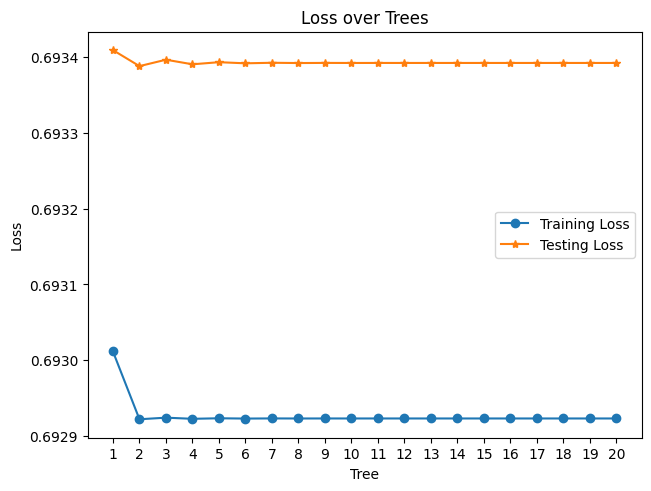

In [52]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=1.5, #0.3, 0.75
        max_depth=8,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)

# sketchs = [DDSketch() for _ in range(total_users)]
# sketch = DDSketch()
res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])
        splitCandidates.append(quantiles)

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}



# client update splits
for i in range(total_users):
    bst_clients[i].setquantiles(splitCandidates_dict)

bst = SFXGBoost(configs[0], loggers[0]) # server model
bst.server_fit(fName,splitCandidates)

# a = FitRes(Status(Code.OK, "OK"), Parameters([bst], ""), 0, {})



# training

for t in range(config.max_tree):
    current_time = time.time()
    print(f"Tree {t}:")
    for d in range(config.max_depth):
        print(f"Depth {d}:")
        GHs = []
        for i in range(total_users):
            GH = bst_clients[i].participant_boost(t, d)
            GHs.append(GH)
        update_info = bst.server_boost(GHs, t, d)
        train_losses = np.array([])
        test_losses = np.array([])
        for i in range(total_users):
            loss = bst_clients[i].participant_update(update_info, t, d) #return train loss and test loss
            train_losses = np.append(train_losses, loss[0])
            test_losses = np.append(test_losses, loss[1])
        if d == config.max_depth - 1:
            print(f"Train loss: {np.mean(train_losses)}")
            print(f"Test loss: {np.mean(test_losses)}")
            bst.losslog_train.append(np.mean(train_losses))
            bst.losslog_test.append(np.mean(test_losses))
            if t == config.max_tree - 1:
                plot_loss(bst.losslog_train,bst.losslog_test,config)
    print(f"Time for tree {t}: {round(time.time() - current_time, 0)}s")
        
        # aggregate the loss from all the clients, log the loss


day = date.today().strftime("%b-%d-%Y")

# curTime = round(time.time())
curTime = time.strftime("%H:%M", time.localtime())

for i in range(total_users):

    
    bst_save = SFXGBoost(configs[i+1], loggers[i+1])

    bst_save.trees = bst_clients[i].trees
    bst_save.fName = fName
    bst_save.X_test = bst_clients[i].X_test
    bst_save.y_test = bst_clients[i].y_test
    bst_save.X_train = bst_clients[i].X_train
    bst_save.y_train = bst_clients[i].y_train

    # print(bst_save.predict(X_train))


    os.makedirs(f'./Saves/{day}', exist_ok=True)
    pickle.dump(bst_save, open(f"./Saves/{day}/model_{curTime.replace(':','_')}_{configs[0].dataset}_{i+1}.pkl", 'wb'))


Accuracy: 0.7252404643449419
Confusion Matrix:
[[10930     2]
 [ 4140     3]]
ROC AUC (macro avg): 0.49995427375461887
ROC AUC (micro avg): 0.49993367160878865
F1 Score (macro avg): 0.42107552070951887
F1 Score (class 0): 0.840704561187601
F1 Score (class 1): 0.0014464802314368371


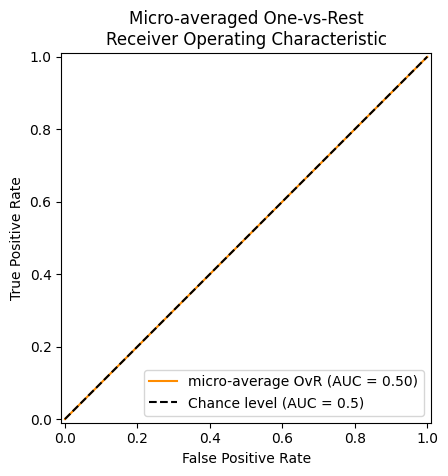

<Figure size 640x480 with 0 Axes>

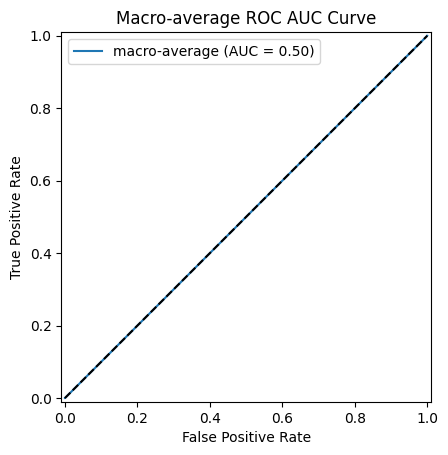

In [53]:
bst_clients = []
# E:\OneDrive\UOB\xgboost-comprehensive\FederBoost\Saves\Jun-24-2024\model_10_29_credit_card_fraud_1.pkl
for i in range(NUM_CLIENTS):
    i += 1
    bst:SFXGBoost = pickle.load(open(f"./Saves/Jun-24-2024/model_23_28_whales_prediction_{i}.pkl", 'rb'))
    bst_clients.append(bst)

X_train = np.concatenate([bst_clients[i].X_train for i in range(NUM_CLIENTS)])
X_test = np.concatenate([bst_clients[i].X_test for i in range(NUM_CLIENTS)])
y_train = np.concatenate([bst_clients[i].y_train for i in range(NUM_CLIENTS)])
y_test = np.concatenate([bst_clients[i].y_test for i in range(NUM_CLIENTS)])


n_classes = y_test.shape[1]
y_test_labels = np.argmax(y_test, axis=1)

y_pred = bst.predict(X_test)
y_pred_prab = bst.predict_proba(X_test)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='macro')
print(f"ROC AUC (macro avg): {roc_auc}")

roc_auc = roc_auc_score(y_test, y_pred_prab, multi_class='ovr', average='micro')
print(f"ROC AUC (micro avg): {roc_auc}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"F1 Score (macro avg): {f1}")

# Calculate F1 score for each class
f1_per_class = f1_score(y_test_labels, y_pred, average=None)
for i, score in enumerate(f1_per_class):
    print(f"F1 Score (class {i}): {score}")

# import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred_prab.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prab[:, i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred_prab, average="macro", multi_class="ovr")

# Plot macro-average ROC curve
plt.figure()
RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], estimator_name='macro-average').plot()

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC AUC Curve')
plt.legend(loc="best")
plt.show()

# print(f'Macro-average ROC AUC: {roc_auc["macro"]}')

In [55]:
y_test_labels.sum()

4143

In [57]:
y_test_labels.shape

(15075,)

: 

In [35]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=0.3, #0.3, 0.75
        max_depth=8,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from numpy import float64
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)


res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.unique(np.round(np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)]), 4)) #improve the bucket
        splitCandidates.append(quantiles)

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}

start DB = 0, end = 5024, myrank = 1
start DB = 5024, end = 10049, myrank = 2
start DB = 10049, end = 15073, myrank = 3


In [36]:
res_to_merge

[[[store: {-282: 0.0, -281: 0.0, -280: 0.0, -279: 0.0, -278: 0.0, -277: 0.0, -276: 0.0, -275: 0.0, -274: 0.0, -273: 0.0, -272: 0.0, -271: 0.0, -270: 0.0, -269: 0.0, -268: 0.0, -267: 0.0, -266: 0.0, -265: 0.0, -264: 0.0, -263: 0.0, -262: 0.0, -261: 0.0, -260: 0.0, -259: 0.0, -258: 0.0, -257: 0.0, -256: 0.0, -255: 0.0, -254: 0.0, -253: 0.0, -252: 0.0, -251: 0.0, -250: 0.0, -249: 0.0, -248: 0.0, -247: 0.0, -246: 0.0, -245: 0.0, -244: 0.0, -243: 0.0, -242: 0.0, -241: 0.0, -240: 0.0, -239: 0.0, -238: 0.0, -237: 0.0, -236: 0.0, -235: 0.0, -234: 0.0, -233: 0.0, -232: 0.0, -231: 0.0, -230: 0.0, -229: 0.0, -228: 0.0, -227: 0.0, -226: 0.0, -225: 0.0, -224: 0.0, -223: 0.0, -222: 0.0, -221: 0.0, -220: 0.0, -219: 113.0, -218: 0.0, -217: 0.0, -216: 0.0, -215: 0.0, -214: 0.0, -213: 0.0, -212: 0.0, -211: 0.0, -210: 0.0, -209: 0.0, -208: 0.0, -207: 0.0, -206: 0.0, -205: 0.0, -204: 0.0, -203: 0.0, -202: 0.0, -201: 0.0, -200: 0.0, -199: 0.0, -198: 0.0, -197: 0.0, -196: 0.0, -195: 0.0, -194: 0.0, -193: 0.

In [37]:
splitCandidates_dict

{'numerical__count_BUY_4': array([-0.201 , -0.1476, -0.0943, -0.0409,  0.0124,  0.0658,  0.1191,  0.1725,  0.2258,  0.2792,  0.3325,  0.3859,  0.4392,  0.4926,  0.5459,  0.5993,  0.6526,  0.706 ,  0.7594,  0.8127,  0.8661,  0.9194,  0.9728,  1.0261,  1.0795,  1.1328,  1.1862,  1.2395,  1.2929,  1.3462,  1.3996,  1.4529,  1.5063,  1.5596,  1.613 ,  1.6664,  1.7197,  1.7731,  1.8264,  1.8798,  1.9331,  1.9865,  2.0398,  2.0932,  2.1465,  2.1999,  2.2532,  2.3066,  2.3599,  2.4133,  2.4666,  2.52  ,  2.5733,  2.6267,  2.6801,  2.7334,  2.7868,  2.8401,  2.8935,  2.9468,  3.0002,  3.0535,  3.1069,  3.1602,  3.2136,  3.3203,  3.3736,  3.427 ,  3.4803,  3.5337,  3.6404,  3.6938,  3.8538,  3.9605,  4.1206,  4.1739,  4.334 ,  4.4941,  4.5474,  4.6008,  4.6541,  4.7075,  4.7608,  4.8675,  4.9742,  5.0809,  5.1876,  5.2943,  5.3477,  5.4544,  5.5611,  5.6145,  5.7212,  5.8279,  5.8812,  5.9346,  5.9879,  6.0413,  6.0946,  6.3614,  6.4148,  6.5748,  6.6815,  6.7349,  6.8949,  6.9483,  7.6419,  7.

In [38]:
splitCandidates_dict['onehot_pca__pca5'].shape

(3,)

In [39]:
splitCandidates_dict['onehot_pca__pca5'][1]

0.0

In [41]:
dataset =  'whales_prediction'# 'iris' #'healthcare'
NUM_CLIENTS = 3
DATA_DEVISION = [1/NUM_CLIENTS] * NUM_CLIENTS

config = Config(experimentName = "experiment 1",
        nameTest= dataset + " test",
        model="normal",
        dataset=dataset,
        lam=0, # 0.1 10
        gamma=0, # 0.5
        alpha=0.0,
        learning_rate=0.3, #0.3, 0.75
        max_depth=8,
        max_tree=20,
        nBuckets=100,
        save=False,
        data_devision=DATA_DEVISION,
        train_size=10_000,
        client=0,
        num_client=NUM_CLIENTS
        )

configs:list[Config] = []
for i in range(config.num_client+1):
    configs.append(Config(experimentName = "experiment 1",
        nameTest= config.nameTest,
        model=config.model,
        dataset=dataset,
        lam=config.lam , # 0.1 10
        gamma=config.gamma, # 0.5
        alpha=config.alpha,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        max_tree=config.max_tree,
        nBuckets=config.nBuckets,
        save=False,
        data_devision=config.data_devision,
        train_size=config.train_size,
        client=i, # 0 is server
        num_client=config.num_client
        ))
                          

loggers = []
for i in range(config.num_client+1):
    loggers.append(MyLogger(configs[i]).logger)


# POSSIBLE_PATHS = ["e:\\oneDrive\\UOB\\Federated_XGBoost_Python-main\\data\\"]
# X_train, y_train, X_test, y_test, fName, X_shadow, y_shadow = getDataBase(config.dataset, POSSIBLE_PATHS, False, config.train_size)()
#ndarray

# from sklearn import datasets

# iris = datasets.load_iris()

# X_train = iris.data

from numpy import float64
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# y_train = encoder.fit_transform(iris.target.reshape(-1, 1)).toarray()

# fName = iris.feature_names

# data = pd.read_csv(r'E:\OneDrive\UOB\Dataset\Credit-Card-Data\Data\Credit Card Fraud Detection.csv')\
#     .groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.1, replace=False, random_state=1))\
#     .sample(frac=1, random_state=1, replace=False)

X_train = train_df_shuffle.values
y_train = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
fName = train_df_shuffle.columns



# split data
total_users = config.num_client # participants

X_train_list = []
y_train_list = []

for rank in range(total_users):
    rank += 1
    X_train_my, y_train_my = devide_D_Train(X_train, y_train, rank, config.data_devision)
    X_train_list.append(X_train_my)
    y_train_list.append(y_train_my)


res_to_merge = []
bst_clients:list[SFXGBoost] = []
for i in range(total_users):
    bst_client = SFXGBoost(configs[i+1], loggers[i+1])   
    res = bst_client.participant_fit(X_train_list[i], y_train_list[i], fName)
    res_to_merge.append(res)
    bst_clients.append(bst_client)

# merge the results in server
splitCandidates = []
for i in range(len(res_to_merge[0])):
    if all([isinstance(res_to_merge[p][i][1], np.ndarray)  for p in range(total_users)]):
        combined_array = np.concatenate([res_to_merge[p][i][1] for p in range(total_users)], axis=0)
        splitCandidates.append(np.unique(combined_array))
    else:
        sketch = DDSketch()
        for j in range(total_users):
            sketch.merge(res_to_merge[j][i][0])
        quantiles = np.array([sketch.get_quantile_value(q/config.nBuckets) for q in range(0, config.nBuckets, 1)])#improve the bucket
        splitCandidates.append(quantiles)

splitCandidates_dict = {fName[i]: splitCandidates[i] for i in range(len(splitCandidates))}

start DB = 0, end = 5024, myrank = 1
start DB = 5024, end = 10049, myrank = 2
start DB = 10049, end = 15073, myrank = 3


In [42]:
splitCandidates_dict

{'numerical__count_BUY_4': array([-0.201 , -0.1476, -0.0943, -0.0409,  0.0124,  0.0658,  0.1191,  0.1725,  0.2258,  0.2792,  0.3325,  0.3859,  0.4392,  0.4926,  0.5459,  0.5993,  0.6526,  0.706 ,  0.7594,  0.8127,  0.8661,  0.9194,  0.9728,  1.0261,  1.0795,  1.1328,  1.1862,  1.2395,  1.2929,  1.3462,  1.3996,  1.4529,  1.5063,  1.5596,  1.613 ,  1.6664,  1.7197,  1.7731,  1.8264,  1.8798,  1.9331,  1.9865,  2.0398,  2.0932,  2.1465,  2.1999,  2.2532,  2.3066,  2.3599,  2.4133,  2.4666,  2.52  ,  2.5733,  2.6267,  2.6801,  2.7334,  2.7868,  2.8401,  2.8935,  2.9468,  3.0002,  3.0535,  3.1069,  3.1602,  3.2136,  3.3203,  3.3736,  3.427 ,  3.4803,  3.5337,  3.6404,  3.6938,  3.8538,  3.9605,  4.1206,  4.1739,  4.334 ,  4.4941,  4.5474,  4.6008,  4.6541,  4.7075,  4.7608,  4.8675,  4.9742,  5.0809,  5.1876,  5.2943,  5.3477,  5.4544,  5.5611,  5.6145,  5.7212,  5.8279,  5.8812,  5.9346,  5.9879,  6.0413,  6.0946,  6.3614,  6.4148,  6.5748,  6.6815,  6.7349,  6.8949,  6.9483,  7.6419,  7.